In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


file_path = '/content/desafio_indicium_imdb.csv'

# Carregar o arquivo CSV usando pandas
df = pd.read_csv(file_path)

# Visualize as primeiras linhas do dataframe para verificar se foi carregado corretamente
print(df.head())

   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  W

In [2]:
!pip freeze > requirements.txt

In [3]:
# carregar os dados
train_data = pd.read_csv('/content/desafio_indicium_imdb.csv')
test_data = pd.read_csv('/content/desafio_indicium_imdb.csv')
sample_submission = pd.read_csv('/content/desafio_indicium_imdb.csv')

In [4]:
# Remover a coluna 'Unnamed: 0', se existir
if 'Unnamed: 0' in df.columns:
   df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Explodir a coluna 'Genre' em múltiplas linhas
df['Genre'] = df['Genre'].str.split(', ')
df_exploded = df.explode('Genre')

### **Exercício 1** Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses relacionadas. Seja criativo!

O exercício 1 vai estar um pouco espalhado pelo código, porque uma EDA não só é importante pra análisar os dados, mas também para analisar e ajudar com a escolha do modelo, entre outros motivos.

In [6]:
# checar os tipos de dados
train_data.dtypes

Unnamed: 0         int64
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

Primeira análise feita dos dados, da pra entender que muitos valores são strings com valores únicos, por exemplo, ator e título do filme, então usar esses valores para machine learning é bem complicado e ruim para a própria IA. Já outros como duração do filme ou classificação, tem valores um pouco semelhantes, então mesmo difícil, tem como trabalhar com eles de um jeito no qual ajuda a IA. Os melhores no geral são os números de voto e Meta score, pois tem dados mais implicantes na variável meta.

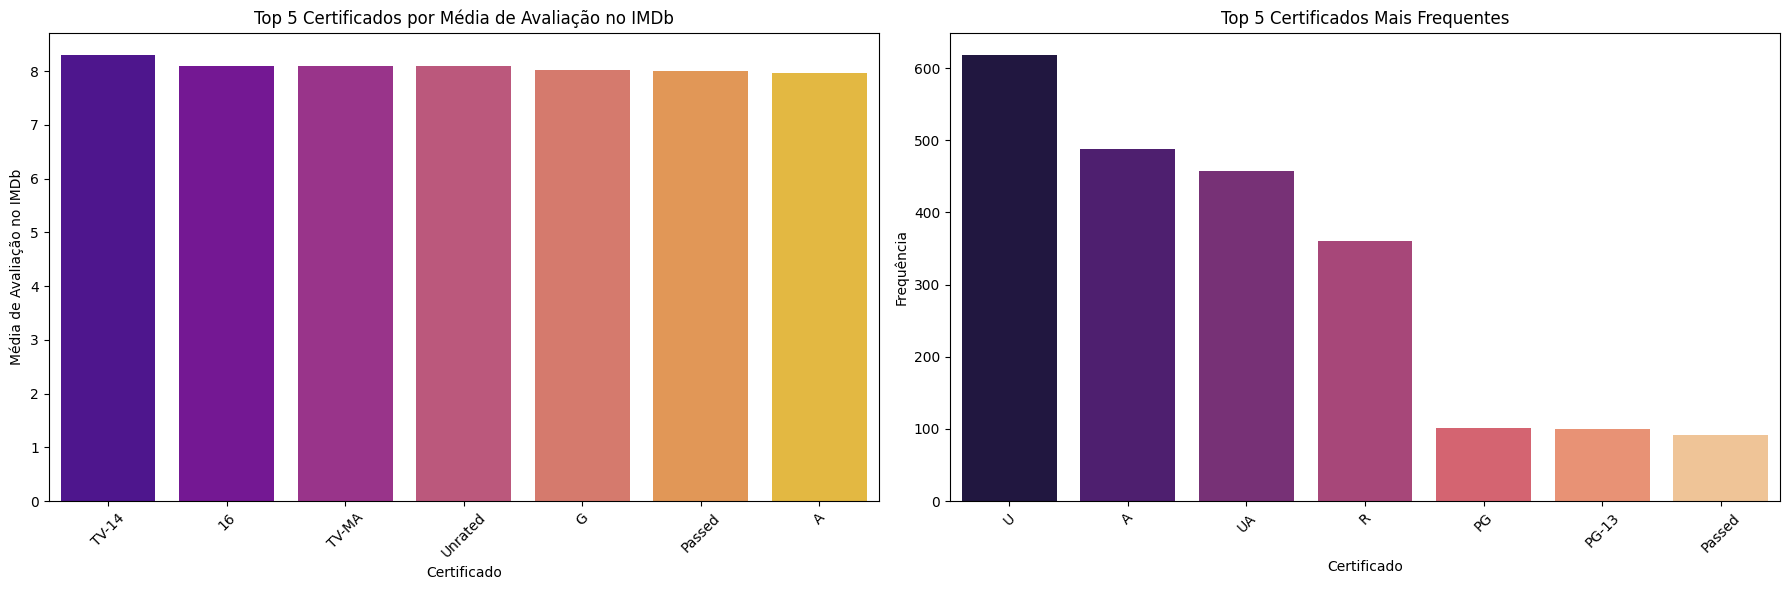

In [7]:
# Calcular a média de IMDB_Rating para cada Certificate
certificate_mean_rating = df_exploded.groupby('Certificate')['IMDB_Rating'].mean().sort_values(ascending=False).head(7)

# Calcular a frequência de cada Certificate
certificate_frequency = df_exploded['Certificate'].value_counts().head(7)

# Transformar em DataFrames para facilitar a plotagem
certificate_mean_rating = certificate_mean_rating.reset_index()
certificate_frequency = certificate_frequency.reset_index()
certificate_frequency.columns = ['Certificate', 'Frequency']

# Adicionar uma coluna dummy para usar como hue
certificate_mean_rating['dummy'] = certificate_mean_rating['Certificate']
certificate_frequency['dummy'] = certificate_frequency['Certificate']

# Plotar os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico de barras vertical da média de IMDB_Rating
sns.barplot(x='Certificate', y='IMDB_Rating', hue='dummy', dodge=False, data=certificate_mean_rating, palette='plasma', ax=axes[0], legend=False)
axes[0].set_title('Top 5 Certificados por Média de Avaliação no IMDb')
axes[0].set_xlabel('Certificado')
axes[0].set_ylabel('Média de Avaliação no IMDb')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de barras vertical da frequência dos certificados
sns.barplot(x='Certificate', y='Frequency', hue='dummy', dodge=False, data=certificate_frequency, palette='magma', ax=axes[1], legend=False)
axes[1].set_title('Top 5 Certificados Mais Frequentes')
axes[1].set_xlabel('Certificado')
axes[1].set_ylabel('Frequência')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Os filmes mais comuns tendem a ser os liberados para todo tipo de público, ou seja, com uma temática mais educacional e menos agressiva. Porém não é tão distante da classificação A, que é uma classificação apenas permitida para pessoas menores de idade, então pode ser que fique fácil classificar e dividir a tabela de aprendizagem entre esses temas, ou pode ser que os filmes estejam todos entrelaçados, sendo um filme com classificação U e outro com classificação A com a mesma nota IMDB.

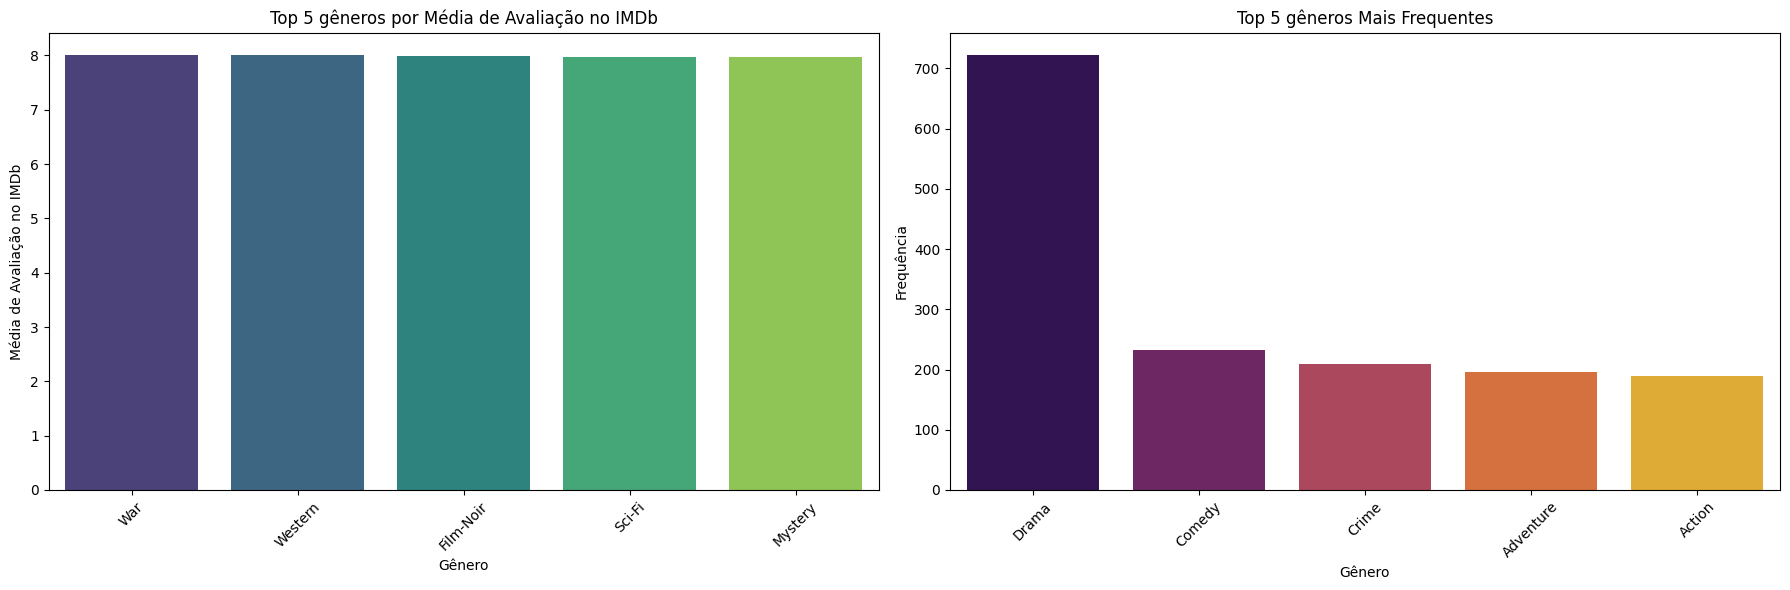

In [8]:
# Calcular a média de IMDB_Rating para cada genero
genre_mean_rating = df_exploded.groupby('Genre')['IMDB_Rating'].mean().sort_values(ascending=False).head(5)

# Calcular a frequência de cada genero
genre_frequency = df_exploded['Genre'].value_counts().head(5)

# Transformar em DataFrames para facilitar a plotagem
genre_mean_rating = genre_mean_rating.reset_index()
genre_frequency = genre_frequency.reset_index()
genre_frequency.columns = ['Genre', 'Frequency']

# Adicionar uma coluna dummy para usar como hue
genre_mean_rating['dummy'] = genre_mean_rating['Genre']
genre_frequency['dummy'] = genre_frequency['Genre']

# Plotar os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico de barras vertical da média de IMDB_Rating
sns.barplot(x='Genre', y='IMDB_Rating', hue='dummy', dodge=False, data=genre_mean_rating, palette='viridis', ax=axes[0], legend=False)
axes[0].set_title('Top 5 gêneros por Média de Avaliação no IMDb')
axes[0].set_xlabel('Gênero')
axes[0].set_ylabel('Média de Avaliação no IMDb')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de barras vertical da frequência dos certificados
sns.barplot(x='Genre', y='Frequency', hue='dummy', dodge=False, data=genre_frequency, palette='inferno', ax=axes[1], legend=False)
axes[1].set_title('Top 5 gêneros Mais Frequentes')
axes[1].set_xlabel('Gênero')
axes[1].set_ylabel('Frequência')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

O gráfico mostra os gêneros com as maiores médias de avaliação IMDB, ou seja, comumente filmes de guerra ou "Western" são mais encontrados quando as notas são maiores que 8. Isso pode facilitar muito o modelo com a aprendizagem. Além de que, nenhum dos gêneros mais comuns, estão com as maiores médias, ou seja, a grande frequencia desses gêneros podem implicar muito em sua média, pois conforme a quantidade aumenta, existem altas chances de existir grande variação da nota, abaixando a média. Outro grande fato também, é que os filmes de gêneros menos comuns, podem ser produzidos com mais cautela e crítica, deixando eles com uma qualidade melhor.

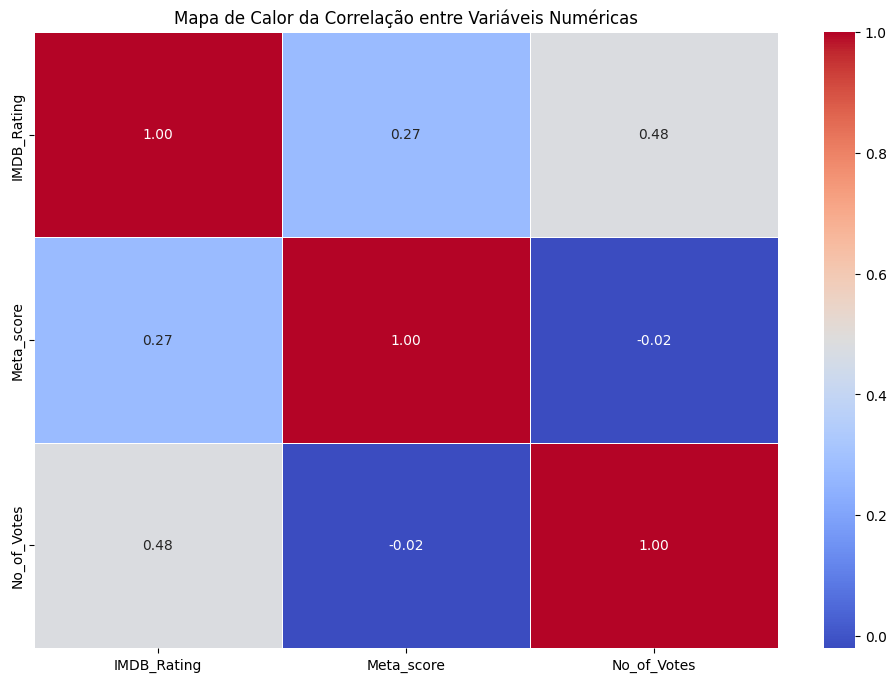

In [9]:
# Selecionar apenas as variáveis numéricas para o heatmap
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calcular a matriz de correlação
correlation_matrix = df[numeric_columns].corr()

# Plotar o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação entre Variáveis Numéricas')
plt.show()

Essa tabela de calor mostra que as mudanças no IMDB Rating de um filme não são facilmente preditas pelas variações em sua pontuação na crítica (Meta_Score) ou pelo número de votos recebidos, ou seja, filmes com altas avaliações no IMDB não necessariamente têm alta pontuação na crítica ou muitos votos, e vice-versa. Ademais, é interessante de se saber que a variação numérica de IMDB_Rating é muito menor do que a de Meta_Score ou No_of_Votes, então as vezes pode ser que a variação sejam bastante diferentes, mas os dois valores sejam altos.

In [10]:
#Analisando informações gerais dos dados
train_data.describe()

,Unnamed: 0,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,999.000000,842.000000,9.990000e+02
mean,500.000000,7.947948,77.969121,2.716214e+05
std,288.530761,0.272290,12.383257,3.209126e+05
min,1.000000,7.600000,28.000000,2.508800e+04
25%,250.500000,7.700000,70.000000,5.547150e+04
50%,500.000000,7.900000,79.000000,1.383560e+05
75%,749.500000,8.100000,87.000000,3.731675e+05
max,999.000000,9.200000,100.000000,2.303232e+06


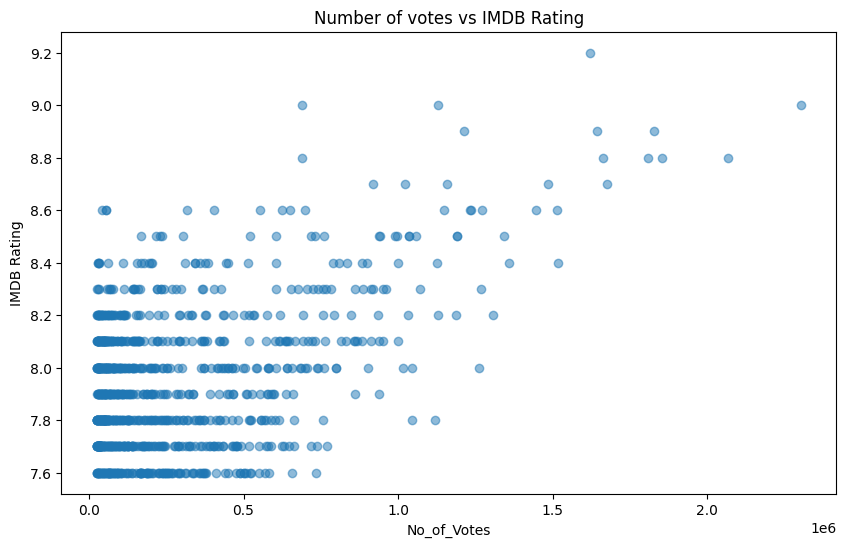

In [11]:
# Criar gráfico de dispersão de 'No_of_Votes' vs 'IMDB_Rating'
plt.figure(figsize=(10, 6))
plt.scatter(df['No_of_Votes'], df['IMDB_Rating'], alpha=0.5)
plt.xlabel('No_of_Votes')
plt.ylabel('IMDB Rating')
plt.title('Number of votes vs IMDB Rating')
plt.show()

Como pode se ver, geralmente quando o número de votos é muito alto, sua nota também tende a ser muito boa.

In [12]:
# Selecionar as colunas desejadas
table = df[['Meta_score', 'IMDB_Rating']]

# Exibir as primeiras linhas da tabela
print(table.head(25))

    Meta_score  IMDB_Rating
0        100.0          9.2
1         84.0          9.0
2         90.0          9.0
3         96.0          9.0
4         94.0          8.9
5         94.0          8.9
6         94.0          8.9
7         74.0          8.8
8         66.0          8.8
9         92.0          8.8
10        82.0          8.8
11        90.0          8.8
12        87.0          8.7
13        73.0          8.7
14        90.0          8.7
15        82.0          8.7
16        83.0          8.7
17        90.0          8.6
18        96.0          8.6
19         NaN          8.6
20        74.0          8.6
21        79.0          8.6
22        96.0          8.6
23        91.0          8.6
24        61.0          8.6


Por exemplo, olhando os índices de 0-24 das colunas "Meta_Score" e "IMDB_Rating", consegui ver um padrão, no qual em muitos casos quanto maior o valor de uma coluna, a outra também tem valor alto.

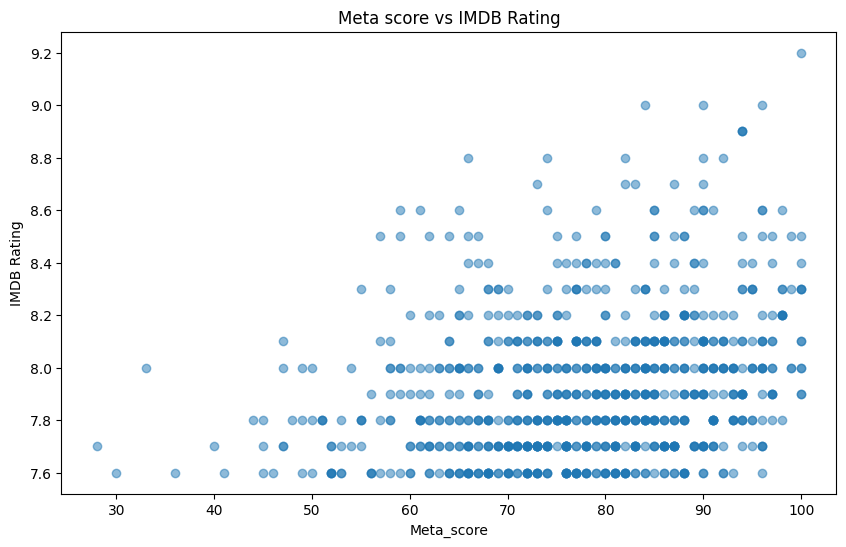

In [13]:
# Criar gráfico de dispersão de 'Meta score' vs 'IMDB_Rating'
plt.figure(figsize=(10, 6))
plt.scatter(df['Meta_score'], df['IMDB_Rating'], alpha=0.5)
plt.xlabel('Meta_score')
plt.ylabel('IMDB Rating')
plt.title('Meta score vs IMDB Rating')
plt.show()

Um gráfico para melhor visualização do quanto Meta score afeta a nota do filme.

### **Hipóteses relacionadas**

- Gêneros populares, como drama e comédia, podem sofrer de saturação de mercado, variando sua qualidade e afetando as notas IMDB reduzindo sua média.

- Filmes com classificação "A", tendem a ser muito mais confiantes para se ter uma nota boa, pois são o segundo mais frequente, e o sétimo com a maior média.

- Nem sempre filmes votados por profissionais (meta score), terá uma nota alta igual a votada pelo público (IMDB), porém, em sua maior parte, quando a nota IMDB é alta, a meta score também será.

- Gêneros menos comuns, como guerras e western, tendem a ser melhores produzidos e nichados, portanto recebem notas mais altas.

- Como 2 dos 3 melhores filmes (do conjunto de dados) em quesito a nota IMDB é de uma mesma saga e de um mesmo autor, há grande chances de que caso exista outro filme com o mesmo título feito pelo mesmo autor também tenha uma nota tão alta quanto.

- A variação de meta score é tão alta, que ao mesmo tempo que pode se haver uma pontuação meta score de 33 (0-100) para um filme com uma nota 8.0 (0-10) no IMDB, pode também haver um filme com nota 100 de meta score para uma nota 9.2 de IMDB.

- Geralmente quando o número de votos tende a ser alto, a nota IMDB também tende a ser muito boa.

### **Exercício 2.a** Qual filme você recomendaria para uma pessoa que você não conhece?

Analisando pela abordagem de tema, existem alguns poucos com uma temática que eu sou facilmente apaixonado, porém o Interstellar é um filme que aborda um gênero muito bom e complicado de trabalhar em cima. Porém, o filme tem uma quantidade alta de faturamento, além de que sua nota IMDB é uma das mais altas sendo um dos filmes mais votados. Consequentemente se espera que o filme seja muito bem produzido e de ótima qualidade. Então eu provavelmente recomendaria Interstellar.

### **Exercício 2.b** Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?


In [14]:
# Converter a coluna 'Gross' para numérico (substituir caracteres não numéricos e converter)
df['Gross'] = df['Gross'].str.replace(',', '').astype(float)

Transformei o faturamento em numérico para ver melhor a comparação entre o faturamento com a alta expectativa de um filme.

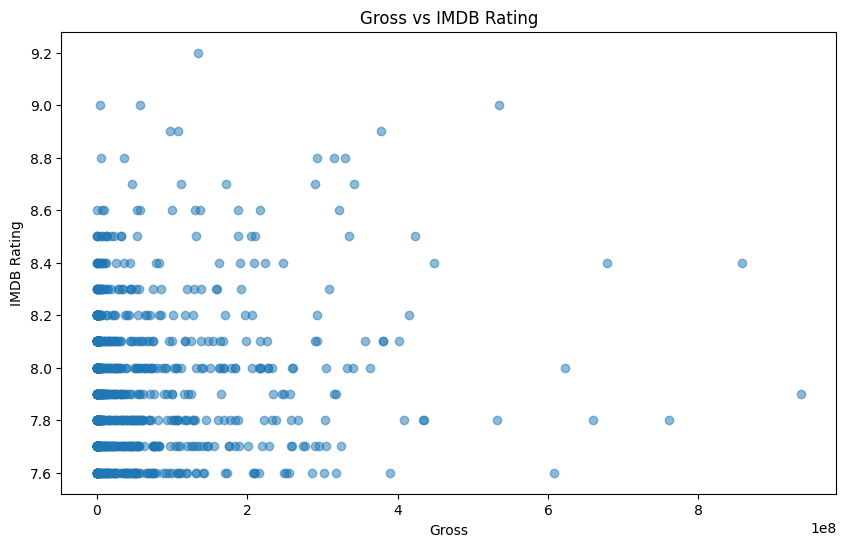

In [15]:
# Criar gráfico de dispersão de 'Gross' vs 'IMDB_Rating'
plt.figure(figsize=(10, 6))
plt.scatter(df['Gross'], df['IMDB_Rating'], alpha=0.5)
plt.xlabel('Gross')
plt.ylabel('IMDB Rating')
plt.title('Gross vs IMDB Rating')
plt.show()

Analisando esse gráfico, percebe-se que nem sempre um alto faturamente significa em um filme com a melhor nota, porém é esperado que quanto maior o faturamento, melhor ele seja. Afinal se eles faturaram tanto, deve ter atiçado a curiosidade de muitos tipos de pessoas com gostos diferentes, além de muitos terem ido rever o filme.

### **Exercício 2.c** Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?


A coluna overview pode fornecer muitas informações sobre o filme, seja o tema, os personagens, o motivo dos personagens, até mesmo sua ambientação. Com ela da pra se analisar muita coisa, até mesmo o gênero do filme, por exemplo, o primeiro filme da tabela dada é "The godfather", e sua overview: "An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.", mostra muita coisa, como por exemplo: o tema do filme que é sobre crime organizado, ou seja, ação; aborda também problemas familiares, que supostamente resulta em drama também.

In [16]:
# Checar quantidade de valores nulos
train_data.isnull().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [17]:
#Visualizando equilibrio da quantidade de dados para teste da coluna Alvo
train_data["IMDB_Rating"].value_counts()

IMDB_Rating
7.7    157
7.8    151
8.0    141
8.1    127
7.6    123
7.9    106
8.2     67
8.3     44
8.4     31
8.5     20
8.6     15
8.8      5
8.7      5
9.0      3
8.9      3
9.2      1
Name: count, dtype: int64

É importante olhar o equilíbrio e a variação da coluna alvo para ver como a IA vai tratar e fazer os testes e previsões. Nesse caso os dados estão todos agrupados com pouca variação, então tem mais chance do modelo chutar os valores nos conjuntos de teste.

In [18]:
# Checar quantidade de valores duplicados
train_data.duplicated().sum()

0

É importante analisar também pra ver se existe alguma linha dos dados que seja igual, para assim se retirar e evitar repetição e padronização na aprendizagem do modelo.


### **Exercício 3** Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Para fazer a previsão da nota imdb, primeiramente vamos olhar as colunas com um dado no qual não interfere diretamente na meta que desejamos. Escolhi algumas colunas com valores quase 100% diferentes, ou seja, é muito difícil mais de um filme com o mesmo nome, ou um resumo igual. E essas informações vão alimentar a IA de um jeito ruim. Além disso, fiz até alguns testes utilizando o modelo de regressão linear e com árvore de decisão utilizando essas colunas e os resultados tiverão precisão negativa, ou seja, as respostas eram aleatórias e estavam fora do valor de alcance. O problema é de um modelo de regressão, pois procuramos valores contínuos e numéricos, ao invés de uma classe, por exemplo. Então a coluna “Meta_score” com “No_of_votes” tem um padrão maior de resultados quando se faz previsão da coluna “IMDB_Rating”, pois se trata de um valor contínuo, e outras como “Overview” ou “Series_Title” servem mais para identar com o que estamos trabalhando. No geral as melhores colunas trabalhadas foram as:

Categorical: “Released_Year”, “Certificate”, “Runtime”, “Genre”, “Gross”

Numericals: “IMDB_Rating”, “Meta_Score”, “No_of_Votes”

Fiz teste utilizando 3 modelos diferentes (Regressão linear, Árvore de decisão, Rede Neural), e analisei a “Mean Square Error” e a “Root Mean Square Error” de todos e comparei cada um, e a conclusão foi que o modelo que teve os melhores valores (aproximado de 0) foi a Árvore de decisão.

Os pros de trabalhar com Árvore de decisão, é que ela é um modelo bem simples e fácil de mexer, não é necessário mexer com a nomalização dos dados, ela lida com dados não lineares além de variáveis categóricas e numéricas, e a melhor parte é que ela faz construção automática de hierarquias, ou seja, ela divide automaticamente as variáveis de entrada em diferentes grupos hierárquicos.

Seus contras são que ela não pega relações muito complexas como por exemplo, uma rede neural, sua estabilidade é muito baixa, então uma pequena mudança de dados já pode alterar todo o esquema de funcionamento de uma árvore.


In [19]:
# Colunas não necessárias
train_data.drop(["Director", "Star1", "Star2", "Star3", "Star4", "Overview", "Series_Title"], axis=1, inplace=True)
test_data.drop(["Director", "Star1", "Star2", "Star3", "Star4", "Overview", "Series_Title"], axis=1, inplace=True)

In [20]:
# Substituir valores ausentes por zero em todo o dataframe
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [21]:
# Convert 'Certificate' column to string type before applying LabelEncoder
train_data['Certificate'] = train_data['Certificate'].astype(str)
test_data['Certificate'] = test_data['Certificate'].astype(str)

# Convert 'Certificate' column to string type before applying LabelEncoder
train_data['Gross'] = train_data['Gross'].astype(str)
test_data['Gross'] = test_data['Gross'].astype(str)

In [22]:
# Exemplo de aplicação do LabelEncoder
label_encoder = LabelEncoder()
train_data['Genre'] = label_encoder.fit_transform(train_data['Genre'])
test_data['Genre'] = label_encoder.transform(test_data['Genre'])

train_data['Certificate'] = label_encoder.fit_transform(train_data['Certificate'])
test_data['Certificate'] = label_encoder.transform(test_data['Certificate'])

train_data['Released_Year'] = label_encoder.fit_transform(train_data['Released_Year'])
test_data['Released_Year'] = label_encoder.transform(test_data['Released_Year'])

train_data['Gross'] = label_encoder.fit_transform(train_data['Gross'])
test_data['Gross'] = label_encoder.transform(test_data['Gross'])

train_data['Runtime'] = label_encoder.fit_transform(train_data['Runtime'])
test_data['Runtime'] = label_encoder.transform(test_data['Runtime'])

In [23]:
# Garantir que test_data tenha as mesmas colunas que train_data
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [24]:
# Dividir os dados em características (X) e alvo (y)
X = train_data.drop("IMDB_Rating", axis=1)
y = train_data["IMDB_Rating"]

In [25]:
# Dividir os dados em conjuntos de treino e teste antes da transformação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensionar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_data_scaled = scaler.transform(test_data.drop("IMDB_Rating", axis=1))

# Converter de volta para DataFrame, se necessário
common_columns = X_train.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=common_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=common_columns)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=common_columns)

Dividi os dados de treino e teste de uma forma 80% para treino e 20% para teste, assim os dados alimentam o modelo de uma forma equivalente e no geral são bons para a aprendizagem. Além de colocar o Random State, para evitar aleatoriedade nos dados apresentados ao modelo e uma padronização na acurácia dele.

In [26]:
# Treinar o modelo de árvore de decisão
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

Primeiramente escolhi o modelo de regressão linear para fazer o treinamento e ver a acurácia do modelo, pois como se trata de um modelo de regressão, optei primeiramente pelo mais padrão. Porém sua acurácia não estava satisfazendo muito, tinha 65% apenas e mesmo mexendo com as colunas ou com seu random state, só piorava a quantidade de erro. Então testei o modelo de árvore de decisão, e sua acurácia teve um valor muito melhor.

In [27]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

In [28]:
# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.00010000000000003038
R^2 Score: 0.9984766315276334


Fiz a avaliação com vários modelos diferentes utilizando principalmente o MSE (Mean Squared Error) e o R2 para acurácia. O melhor deles foi o da árvore de decisão com 99%.

In [29]:
# Fazer previsões no conjunto de teste
predictions = model.predict(test_data_scaled)

In [30]:
# Arredondar previsões para duas casas decimais
predictions = np.round(predictions, 2)

In [31]:
#print (predictions)

Caso queira ver os números do conjunto de teste, só retirar a '#' da célula acima.

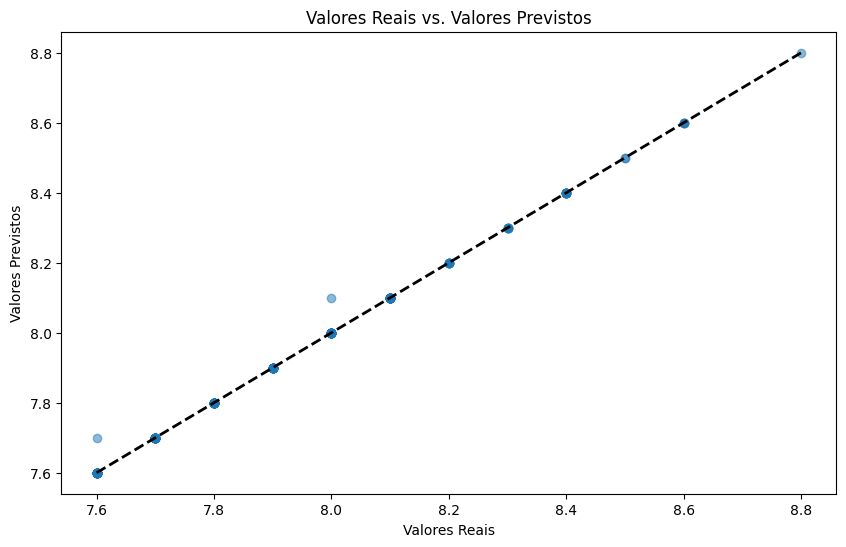

In [32]:
import matplotlib.pyplot as plt

# Plotar gráfico de dispersão dos valores reais vs. valores previstos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Valores Previstos')
plt.show()

Aqui tem um gráfico mostrando a linha entre os resultados corretos e os resultados que foram previstos pela máquina. A linha representa os resultados esperados e as bolinhas azuis são os resultados que a máquina previu.

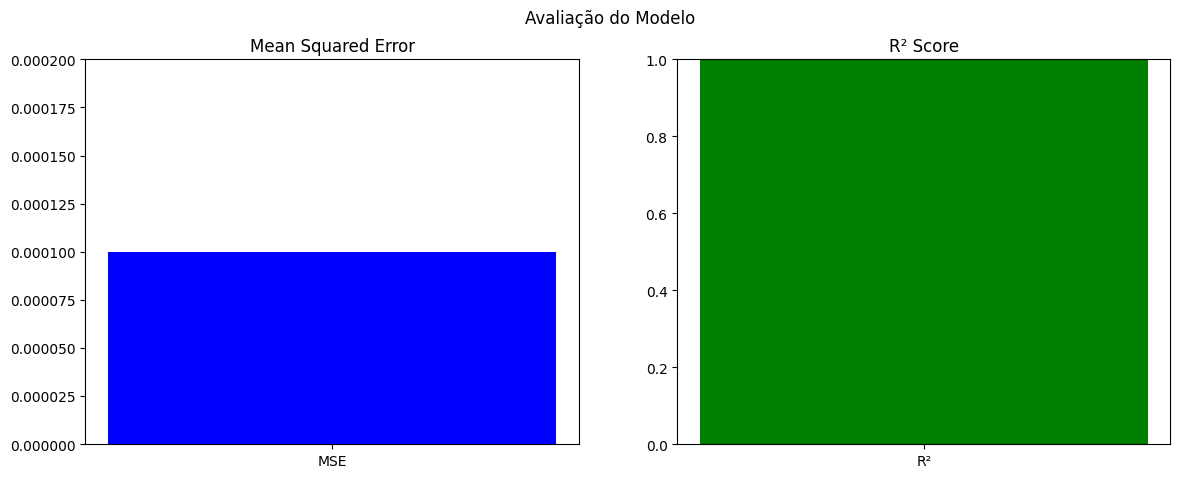

In [33]:
# Gráfico de MSE e R²
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# MSE
ax[0].bar(['MSE'], [mse], color='blue')
ax[0].set_title('Mean Squared Error')
ax[0].set_ylim(0, mse * 2)

# R²
ax[1].bar(['R²'], [r2], color='green')
ax[1].set_title('R² Score')
ax[1].set_ylim(0, 1)

plt.suptitle('Avaliação do Modelo')
plt.show()

Um gráfico para melhor visualização da porcentagem de erro e da acurácia do modelo.

In [34]:
with open("modelo_arvore.pkl", "wb") as arquivo:
  pickle.dump(model, arquivo)

Salvando modelo em .pkl

In [35]:
# Carregar o arquivo Prediction.xlsx
prediction_data = pd.read_csv('/content/previsao.csv')

print(prediction_data.head())

   Unnamed: 0              Series_Title  Released_Year Certificate  Runtime  \
0           1  The Shawshank Redemption           1994           A  142 min   

   Genre                                           Overview  Meta_score  \
0  Drama  Two imprisoned men bond over a number of years...        80.0   

         Director        Star1           Star2       Star3           Star4  \
0  Frank Darabont  Tim Robbins  Morgan Freeman  Bob Gunton  William Sadler   

   No_of_Votes       Gross  
0      2343110  28,341,469  


Carregando o arquivo excel de teste do exercício 4 de entrega.

In [36]:
# Aplicar as mesmas transformações aos dados de previsão
prediction_data.drop(["Director", "Star1", "Star2", "Star3", "Star4", "Overview", "Series_Title"], axis=1, inplace=True)

In [37]:
# Exemplo de aplicação do LabelEncoder
label_encoder = LabelEncoder()
prediction_data['Genre'] = label_encoder.fit_transform(prediction_data['Genre'])

prediction_data['Certificate'] = label_encoder.fit_transform(prediction_data['Certificate'])

prediction_data['Released_Year'] = label_encoder.fit_transform(prediction_data['Released_Year'])

prediction_data['Gross'] = label_encoder.fit_transform(prediction_data['Gross'])

prediction_data['Runtime'] = label_encoder.fit_transform(prediction_data['Runtime'])


In [38]:
# Garantir que prediction_data tenha as mesmas colunas que X
prediction_data, _ = prediction_data.align(X, join='right', axis=1, fill_value=0)

Deixando os dados iguais os dados usados para treino e teste.

In [39]:
# Redimensionar os dados de previsão
prediction_data_scaled = scaler.transform(prediction_data)

# Converter de volta para DataFrame com os nomes das colunas
prediction_data_scaled = pd.DataFrame(prediction_data_scaled, columns=prediction_data.columns)

In [40]:
# Fazer previsões
predictions = model.predict(prediction_data_scaled)

In [41]:
# Arredondar previsões para duas casas decimais
predictions = np.round(predictions, 2)

In [42]:
# Salvar as previsões em um novo arquivo Excel
output_df = pd.DataFrame(predictions, columns=["IMDB_Rating"])
output_df.to_excel('/content/Predictions_Output.xlsx', index=False)

### **Exercício 4-** Supondo um filme com as seguintes características:

### Qual seria a nota do IMDB?


In [43]:
print(predictions)

[9.2]


A previsão do modelo de árvore de decisão no exercício de entrega 4 foi de 9.2 como visto na célula acima.